# Imports, Data & Helper Functions

In [92]:
# System and Environment Imports
import os
import json
import math
import time
from datetime import datetime
import logging
from multiprocessing import Pool, cpu_count
from dotenv import load_dotenv

# Database Connectivity
from sqlalchemy import create_engine, text

# Data Manipulation and Analysis
import pandas as pd
import numpy as np
import scipy
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
# from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from prophet import Prophet

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and Clustering
# from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import silhouette_score, make_scorer, adjusted_rand_score, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
import umap.umap_ as umap

# Load environment variables
load_dotenv(verbose=True, encoding='utf-8')

True

In [5]:
# Database connection
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")
db_name = os.getenv("DB_NAME")

db_conn_string = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
db_conn_query = """
select implementation_info_name key, character_value as value
from mimiciv.information_schema.sql_implementation_info
where implementation_info_name like 'DBMS %'
"""


def setup_db_connection(conn_string: str, conn_query: str):
    try:
        base_engine = create_engine(conn_string)
        with base_engine.connect() as conn:
            conn.execute(text(conn_query))
        return base_engine
    except Exception as e:
        # Catch any unexpected exceptions and escalate as critical
        raise


engine = setup_db_connection(conn_string=db_conn_string, conn_query=db_conn_query)

In [6]:
# generic plots
# plot_histogram(data, 'age', bins=10, title="Age Distribution", xlabel="Age (years)")
def plot_histogram(data, column, bins=20, title=None, xlabel=None, ylabel="Frequency"):
    """
    Creates a histogram for a specific column in the dataset.
    
    Parameters:
    - data: pandas DataFrame
    - column: str, column name for which the histogram is created
    - bins: int, number of bins for the histogram (default: 20)
    - title: str, title of the plot (default: None)
    - xlabel: str, label for the x-axis (default: None)
    - ylabel: str, label for the y-axis (default: "Frequency")
    """
    plt.figure(figsize=(8, 6))
    plt.hist(data[column].dropna(), bins=bins, color='blue', edgecolor='black')
    plt.title(title if title else f"Histogram of {column}")
    plt.xlabel(xlabel if xlabel else column)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


def plot_histogram_r1(data, column, bins=20, title=None, xlabel=None, ylabel="Frequency"):
    mean_val = data[column].mean()
    std_val = data[column].std()
    col_data = data[column].dropna()

    # 1 std away (red)
    data_1std = col_data[(col_data < mean_val - std_val) | (col_data > mean_val + std_val)]

    # 5% away but not beyond 1 std (yellow)
    data_5pct = col_data[~col_data.index.isin(data_1std.index) &
                         ((col_data < mean_val * 0.95) | (col_data > mean_val * 1.05))]

    # Within 5% (blue)
    data_normal = col_data[~col_data.index.isin(data_1std.index) & ~col_data.index.isin(data_5pct.index)]

    plt.figure(figsize=(8, 6))
    # Plot normal (blue)
    plt.hist(data_normal, bins=bins, color='blue', edgecolor='black', alpha=0.7, label='Within 5%')
    # Plot 5% away (yellow)
    plt.hist(data_5pct, bins=bins, color='yellow', edgecolor='black', alpha=0.7, label='>5% away')
    # Plot >1std away (red)
    plt.hist(data_1std, bins=bins, color='red', edgecolor='black', alpha=0.7, label='>1 std away')

    plt.title(title if title else f"Histogram of {column}")
    plt.xlabel(xlabel if xlabel else column)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()


# plot_scatter(data, 'age', 'blood_pressure', title="Blood Pressure vs Age", xlabel="Age", ylabel="Blood Pressure")
def plot_scatter(data, x_col, y_col, title=None, xlabel=None, ylabel=None, alpha=0.7):
    """
    Creates a scatter plot for two columns in the dataset.
    
    Parameters:
    - data: pandas DataFrame
    - x_col: str, column name for the x-axis
    - y_col: str, column name for the y-axis
    - title: str, title of the plot (default: None)
    - xlabel: str, label for the x-axis (default: None)
    - ylabel: str, label for the y-axis (default: None)
    - alpha: float, transparency of the points (default: 0.7)
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(data[x_col], data[y_col], alpha=alpha, color='blue')
    plt.title(title if title else f"Scatter Plot of {y_col} vs {x_col}")
    plt.xlabel(xlabel if xlabel else x_col)
    plt.ylabel(ylabel if ylabel else y_col)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


# plot_line(data, 'timestamp', 'heart_rate', title="Heart Rate Over Time", xlabel="Timestamp", ylabel="Heart Rate (bpm)")
def plot_line(data, x_col, y_col, title=None, xlabel=None, ylabel=None):
    """
    Creates a line plot for two columns in the dataset.
    
    Parameters:
    - data: pandas DataFrame
    - x_col: str, column name for the x-axis
    - y_col: str, column name for the y-axis
    - title: str, title of the plot (default: None)
    - xlabel: str, label for the x-axis (default: None)
    - ylabel: str, label for the y-axis (default: None)
    """
    plt.figure(figsize=(8, 6))
    plt.plot(data[x_col], data[y_col], color='blue', marker='o', linestyle='-')
    plt.title(title if title else f"Line Plot of {y_col} over {x_col}")
    plt.xlabel(xlabel if xlabel else x_col)
    plt.ylabel(ylabel if ylabel else y_col)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


def plot_heatmap(data, col1, col2, cmap="coolwarm", annot=True):
    """
    Plots a heatmap for the correlation between two float64 columns.

    Parameters:
    - data: pandas DataFrame
    - col1: str, the first column name
    - col2: str, the second column name
    - cmap: str, the colormap for the heatmap (default: "coolwarm")
    - annot: bool, whether to annotate the heatmap with correlation values (default: True)
    """
    # Extract the two columns and compute the correlation
    corr = data[[col1, col2]].corr()

    # Plot the heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr, annot=annot, cmap=cmap, cbar=True, square=True, fmt=".2f")
    plt.title(f"Correlation Heatmap: {col1} and {col2}")
    plt.tight_layout()
    plt.show()


def plot_correlation_matrix(corr_matrix, cmap="coolwarm", annot=True):
    """
    Plots a heatmap for an existing correlation matrix.

    Parameters:
    - corr_matrix: pandas DataFrame, the existing correlation matrix
    - cmap: str, the colormap for the heatmap (default: "coolwarm")
    - annot: bool, whether to annotate the heatmap with correlation values (default: True)
    """
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr_matrix, annot=annot, cmap=cmap, cbar=True, square=True, fmt=".2f",
                xticklabels=corr_matrix.columns, yticklabels=corr_matrix.index)
    plt.title("Correlation Matrix Heatmap")
    plt.tight_layout()
    plt.show()



def plot_histogram_alt(data, column, bins=20, title=None, xlabel=None, ylabel="Frequency"):
    mean_val = data[column].mean()
    std_val = data[column].std()
    col_data = data[column].dropna()

    # Categorize data points, ensuring indexing is consistent
    cat_red = col_data[(col_data < mean_val - std_val) | (col_data > mean_val + std_val)]
    cat_yellow = col_data[~col_data.index.isin(cat_red.index) &
                          ((col_data < mean_val * 0.95) | (col_data > mean_val * 1.05))]
    cat_blue = col_data[~col_data.index.isin(cat_red.index) & ~col_data.index.isin(cat_yellow.index)]

    # Compute histogram bins for the entire dataset
    counts, bin_edges = np.histogram(col_data, bins=bins)

    # Function to find which categories fall into a given bin
    def in_bin(values, left, right):
        return values[(values >= left) & (values < right)]

    bin_colors = []
    bin_alphas = []

    for i in range(len(bin_edges)-1):
        left, right = bin_edges[i], bin_edges[i+1]

        red_in_bin = len(in_bin(cat_red, left, right)) > 0
        yellow_in_bin = len(in_bin(cat_yellow, left, right)) > 0
        blue_in_bin = len(in_bin(cat_blue, left, right)) > 0

        if red_in_bin:
            # Priority: red
            color = 'red'
            overlapping = yellow_in_bin or blue_in_bin
            alpha = 0.7 if overlapping else 1.0
        elif yellow_in_bin:
            # Next priority: yellow
            color = 'yellow'
            overlapping = blue_in_bin
            alpha = 0.7 if overlapping else 1.0
        else:
            # Otherwise: blue (or empty)
            if blue_in_bin:
                color = 'blue'
                alpha = 1.0
            else:
                # If empty, just a faint blue
                color = 'blue'
                alpha = 0.1

        bin_colors.append(color)
        bin_alphas.append(alpha)

    plt.figure(figsize=(8, 6))
    for i in range(len(bin_edges)-1):
        plt.bar((bin_edges[i] + bin_edges[i+1]) / 2,
                counts[i],
                width=bin_edges[i+1]-bin_edges[i],
                color=bin_colors[i],
                alpha=bin_alphas[i],
                edgecolor='black')

    plt.title(title if title else f"Histogram of {column}")
    plt.xlabel(xlabel if xlabel else column)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
def plot_scatter_alt(data, x_col, y_col, title=None, xlabel=None, ylabel=None, alpha=0.7):
    # Drop NaNs
    data = data.dropna(subset=[x_col, y_col])

    # Compute stats for x and y
    x_mean, x_std = data[x_col].mean(), data[x_col].std()
    y_mean, y_std = data[y_col].mean(), data[y_col].std()

    # Helper function to classify a single value
    # Returns an integer: 2 for >1 std, 1 for >5%, 0 for within 5%
    def classify(val, mean, std):
        if val < mean - std or val > mean + std:
            return 2
        elif val < mean * 0.95 or val > mean * 1.05:
            return 1
        else:
            return 0

    x_states = data[x_col].apply(lambda v: classify(v, x_mean, x_std))
    y_states = data[y_col].apply(lambda v: classify(v, y_mean, y_std))

    # Determine a combined state
    # If either is 2 -> red
    # else if either is 1 -> yellow
    # else -> blue
    combined_states = np.maximum(x_states, y_states)

    color_map = {
        0: 'blue',     # Both within 5%
        1: 'yellow',   # One or both >5% but not >1 std
        2: 'red'       # One or both >1 std
    }

    point_colors = [color_map[state] for state in combined_states]

    plt.figure(figsize=(8, 6))
    plt.scatter(data[x_col], data[y_col], c=point_colors, alpha=alpha, edgecolor='black')
    plt.title(title if title else f"Scatter Plot of {y_col} vs {x_col}")
    plt.xlabel(xlabel if xlabel else x_col)
    plt.ylabel(ylabel if ylabel else y_col)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Add legend
    plt.scatter([], [], c='blue', edgecolor='black', alpha=alpha, label='Within 5% (both)')
    plt.scatter([], [], c='yellow', edgecolor='black', alpha=alpha, label='>5% away')
    plt.scatter([], [], c='red', edgecolor='black', alpha=alpha, label='>1 std away')

    plt.legend(title="Deviation Categories")
    plt.show()

In [110]:
def plr():
    # Get the current local time
    local_time = datetime.now()
    
    # Format the time as short y/m/d
    formatted_time = local_time.strftime('%y/%m/%d %H:%M:%S')
    print(f"@{formatted_time}")


def col_health_check(df, col_name, inc_series_gaps: bool = False, series_freq: str = 'D'):
    """Query and print a range of common DataFrame and Column values, for quick reference"""
    print()
    print(f'### Data for: {col_name} ###')
    print(f"Col Type: {df[col_name].dtype} | Numeric: {df[col_name].apply(pd.to_numeric, errors='coerce').isna().any()}")
    print(f'Counts: Nulls={df[col_name].isna().sum()} | Duplicates={df[col_name].duplicated().sum()} | Unique Values={df[col_name].nunique()}', )
    if inc_series_gaps:
        inner_df = df.sort_values(col_name)
        missing_dates = pd.date_range(
            start=inner_df[col_name].min(),
            end=inner_df[col_name].max(),
            freq=series_freq
        ).difference(inner_df[col_name])
        print('Series Gaps Count:', len(missing_dates))


# Diagnoses Data | `ddf`

In [12]:
# ddf = pd.read_sql_query("""select * from mimiciv.mimiciv_hosp.diagnoses_icd""", engine)

# Pharmacy Data | pdf

In [ ]:
pharm_query = """select subject_id, starttime, medication"""
pdf = pd

# Vitals Data | `vdf`

In [13]:
vdf = pd.read_sql_query("""select * from mimiciv.mimiciv_derived.vitalsign""", engine)

In [29]:
# vdf_from_db = vdf.copy() 
# vdf = pd.read_csv('vitals_df.csv')
# vdf = vdf.iloc[:, 1:]

In [14]:
vdf.head()

,subject_id,stay_id,charttime,heart_rate,sbp,dbp,mbp,sbp_ni,dbp_ni,mbp_ni,resp_rate,temperature,temperature_site,spo2,glucose
0,14845496,33531189,2159-10-14 00:00:00,103.0,NaN,NaN,NaN,NaN,NaN,NaN,17.0,37.0,Oral,96.0,NaN
1,14845496,33531189,2159-10-14 00:01:00,NaN,100.0,60.0,73.0,100.0,60.0,73.0,NaN,NaN,None,NaN,NaN
2,14845496,33531189,2159-10-14 00:21:00,NaN,73.0,60.0,66.0,73.0,60.0,66.0,NaN,NaN,None,NaN,NaN
3,14845496,33531189,2159-10-14 00:23:00,NaN,85.0,61.0,69.0,85.0,61.0,69.0,NaN,NaN,None,NaN,NaN
4,14845496,33531189,2159-10-14 01:00:00,101.0,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,None,96.0,NaN


In [15]:
print(vdf.shape)
print('---')
print(vdf.info())

(13519533, 15)
---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13519533 entries, 0 to 13519532
Data columns (total 15 columns):
 #   Column            Dtype         
---  ------            -----         
 0   subject_id        int64         
 1   stay_id           int64         
 2   charttime         datetime64[ns]
 3   heart_rate        float64       
 4   sbp               float64       
 5   dbp               float64       
 6   mbp               float64       
 7   sbp_ni            float64       
 8   dbp_ni            float64       
 9   mbp_ni            float64       
 10  resp_rate         float64       
 11  temperature       float64       
 12  temperature_site  object        
 13  spo2              float64       
 14  glucose           float64       
dtypes: datetime64[ns](1), float64(11), int64(2), object(1)
memory usage: 1.5+ GB
None


In [17]:
cols_vitals = ['heart_rate', 'resp_rate', 'mbp', 'temperature', 'spo2']
cols_to_use = ['subject_id', 'heart_rate', 'mbp', 'resp_rate', 'temperature', 'spo2']
cols_to_use_time = ['charttime','subject_id','heart_rate','resp_rate','mbp','temperature','spo2']

# Unsupervised Models: `UMAP`, `KMEANS`, `DBSCAN`
This section creates common models with the reduced sample size (from above).  
Includes log for `IQR` outliers, and `UMAP` dimensionality reduction. 

In [19]:
# Initialize new/copied df
df = vdf[cols_to_use_time].copy()

# Convert chart_time to datetime if not already
df['charttime'] = pd.to_datetime(df['charttime'], errors='coerce')

# Average subject's records into daily frequency
# Extract the date from chart_time
df['charttime'] = df['charttime'].dt.date
# Group by subject_id and date, take mean of each metric (mean() excludes NaN)
df = df.groupby(['subject_id', 'charttime'], as_index=False)[['heart_rate','resp_rate','mbp','temperature','spo2']].mean()
# Restore charttime column to datetime format
# df['charttime'] = pd.to_datetime(df['charttime'])

# Take a 5% sample of subject_ids
unique_subjects = df['subject_id'].unique()
sample_size = int(len(unique_subjects)*0.05)
np.random.seed(42)  # for reproducibility
sampled_subjects = np.random.choice(unique_subjects, size=sample_size, replace=False)

# Filter df to only include the sampled subject_ids
df = df[df['subject_id'].isin(sampled_subjects)]

print("Expecting to see a reduction in rows:")
print(df.shape)
df = df.dropna()
print(df.shape)
print('---')
plr()

Expecting to see a reduction in rows:
(21538, 7)
(20350, 7)
---
Run @ 24/12/10 14:18:50


In [20]:
# IQR-based outlier removal
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Scale data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[cols_vitals])
plr()

Run @ 24/12/10 14:18:58


In [21]:
# UMAP Embedding
reducer = umap.UMAP(n_neighbors=50, min_dist=0.3, random_state=42, n_jobs=1)
embedding = reducer.fit_transform(scaled_data)
df['umap_x'] = embedding[:, 0]
df['umap_y'] = embedding[:, 1]
plr()

C:\Users\steve\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Run @ 24/12/10 14:19:33


In [22]:
# KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)
df['kmeans_cluster'] = kmeans_labels

distances = kmeans.transform(scaled_data)
df['distance_to_center'] = [distances[i, lbl] for i, lbl in enumerate(kmeans_labels)]
threshold = np.percentile(df['distance_to_center'], 95)
df['kmeans_outlier'] = df['distance_to_center'] > threshold
plr()

Run @ 24/12/10 14:19:34


In [23]:
# DBSCAN (Original Space)
dbscan = DBSCAN(eps=0.50, min_samples=10)
db_labels = dbscan.fit_predict(scaled_data)
df['dbscan_label'] = db_labels
df['dbscan_outlier'] = (db_labels == -1)
plr()

Run @ 24/12/10 14:19:34


In [24]:
# DBSCAN on UMAP Embedding
dbscan_umap = DBSCAN(eps=0.50, min_samples=10)
umap_labels = dbscan_umap.fit_predict(embedding)
df['umap_dbscan_label'] = umap_labels
df['umap_dbscan_outlier'] = (umap_labels == -1)
plr()

Run @ 24/12/10 14:19:35


In [25]:
def outlier_category(row):
    km = row['kmeans_outlier']
    db = row['dbscan_outlier']
    ud = row['umap_dbscan_outlier']
    outlier_methods = []
    if km:
        outlier_methods.append('KMeans')
    if db:
        outlier_methods.append('DBSCAN')
    if ud:
        outlier_methods.append('UMAP_DBSCAN')
    if len(outlier_methods) == 0:
        return 'No Outlier'
    return ' & '.join(outlier_methods)


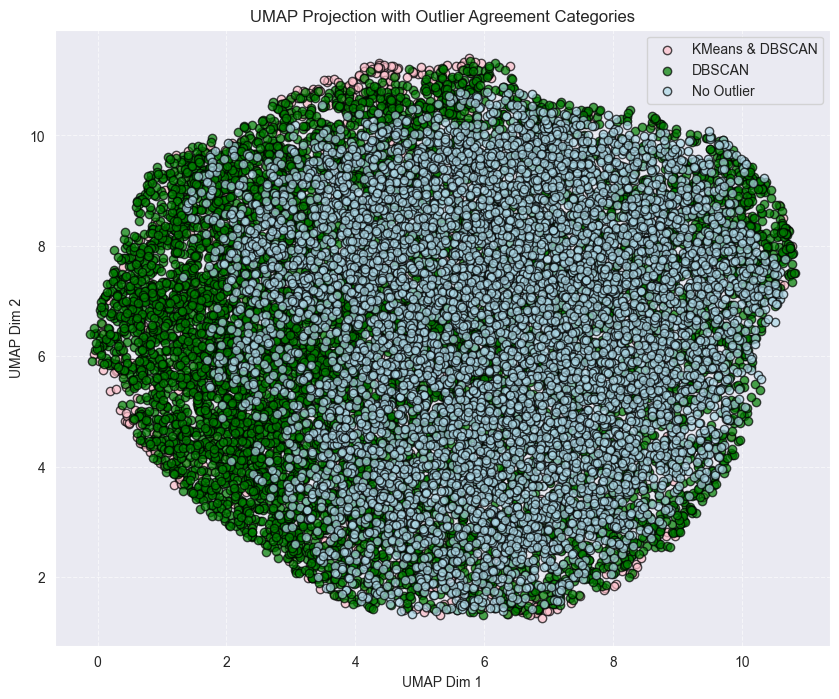

In [26]:
# Create a Combined Outlier Category
df['outlier_combination'] = df.apply(outlier_category, axis=1)

# Define colors for each combination
color_map = {
    'No Outlier': 'lightblue',
    'KMeans': 'orange',
    'DBSCAN': 'green',
    'UMAP_DBSCAN': 'yellow',
    'KMeans & DBSCAN': 'pink',
    'KMeans & UMAP_DBSCAN': 'purple',
    'DBSCAN & UMAP_DBSCAN': 'brown',
    'KMeans & DBSCAN & UMAP_DBSCAN': 'red'
}

# =========================================
# Visualization
# =========================================
plt.figure(figsize=(10,8))

categories = df['outlier_combination'].unique()

for cat in categories:
    cat_points = df[df['outlier_combination'] == cat]
    plt.scatter(cat_points['umap_x'], cat_points['umap_y'],
                color=color_map[cat],
                alpha=0.7,
                edgecolor='black',
                label=cat)

plt.title("UMAP Projection with Outlier Agreement Categories")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


In [27]:
# to inspect results, after models + visual
print(df.shape)
df.head(25)

(18273, 17)


,subject_id,charttime,heart_rate,resp_rate,mbp,temperature,spo2,umap_x,umap_y,kmeans_cluster,distance_to_center,kmeans_outlier,dbscan_label,dbscan_outlier,umap_dbscan_label,umap_dbscan_outlier,outlier_combination
303,10006053,2111-11-14,104.074074,24.517241,73.820000,36.080000,97.814815,4.222461,10.868479,2,2.903607,True,-1,True,0,False,KMeans & DBSCAN
304,10006053,2111-11-15,95.736842,21.388889,60.294118,37.211667,93.125000,3.489141,7.247446,2,2.254773,False,-1,True,0,False,DBSCAN
354,10008100,2181-12-10,86.250000,18.000000,98.000000,35.890000,99.000000,8.803664,3.181862,0,2.796236,False,-1,True,0,False,DBSCAN
355,10008100,2181-12-11,74.928571,17.692308,83.000000,36.430000,97.923077,9.348326,7.565651,0,0.799730,False,0,False,0,False,No Outlier
564,10012476,2163-01-10,56.480000,15.120000,65.200000,36.731667,98.458333,10.061695,7.017820,0,1.848693,False,-1,True,0,False,DBSCAN
565,10012476,2163-01-11,62.571429,17.714286,71.500000,36.805000,97.928571,9.351826,6.645303,0,1.118183,False,0,False,0,False,No Outlier
678,10015625,2177-02-11,75.562500,20.294118,76.368421,37.140000,95.312500,5.334677,5.884121,2,1.201156,False,0,False,0,False,No Outlier
679,10015625,2177-02-12,77.750000,25.346154,61.166667,37.178333,97.791667,3.710568,9.550111,1,2.414600,False,-1,True,0,False,DBSCAN
680,10015625,2177-02-13,69.000000,18.320000,68.833333,36.971667,98.166667,8.216176,7.439947,0,1.218752,False,0,False,0,False,No Outlier
681,10015625,2177-02-14,67.520000,16.423077,78.243902,36.766667,97.720000,9.357099,5.754797,0,0.634931,False,0,False,0,False,No Outlier


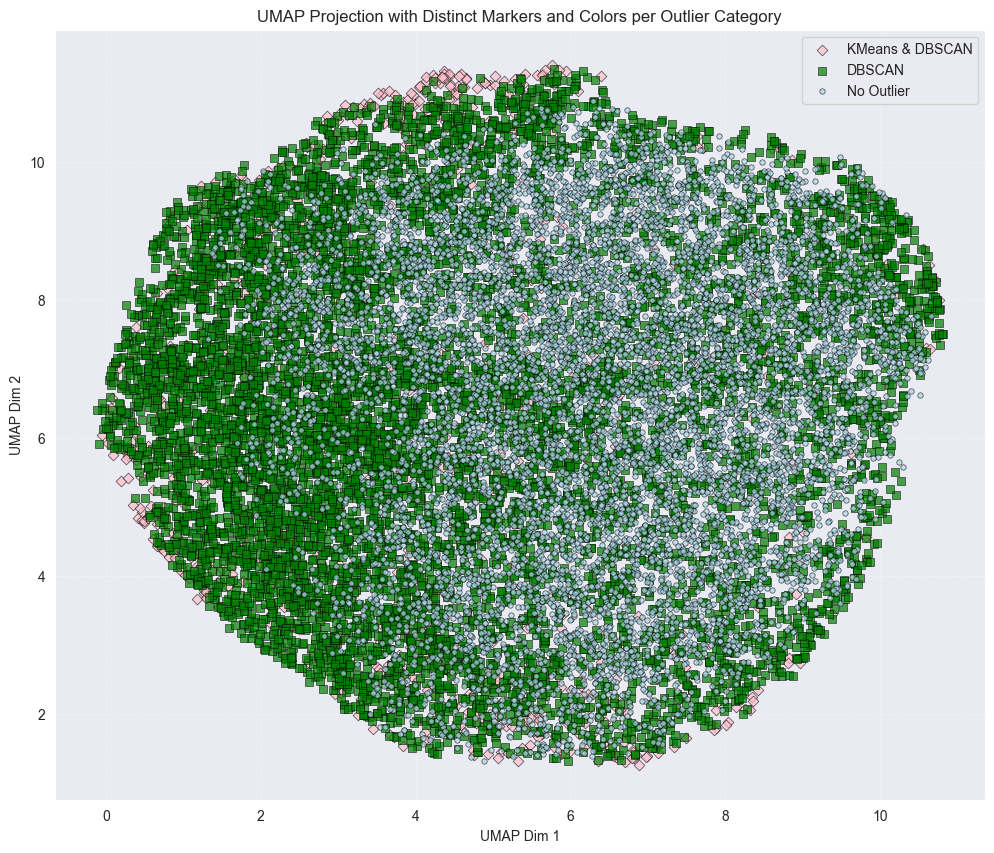

In [28]:
# Define marker and color choices for better distinction
category_marker_map = {
    'No Outlier': ('o', 'lightblue'),
    'KMeans': ('v', 'orange'),
    'DBSCAN': ('s', 'green'),
    'UMAP_DBSCAN': ('P', 'yellow'),
    'KMeans & DBSCAN': ('D', 'pink'),
    'KMeans & UMAP_DBSCAN': ('>', 'purple'),
    'DBSCAN & UMAP_DBSCAN': ('<', 'brown'),
    'KMeans & DBSCAN & UMAP_DBSCAN': ('X', 'red')
}

plt.figure(figsize=(12, 10))

categories = df['outlier_combination'].unique()

for cat in categories:
    cat_points = df[df['outlier_combination'] == cat]
    marker, color = category_marker_map[cat]
    # Make outliers slightly larger
    size = 30 if 'No Outlier' not in cat else 15
    plt.scatter(cat_points['umap_x'], cat_points['umap_y'],
                color=color, marker=marker, s=size,
                alpha=0.7, edgecolor='black', linewidths=0.5,
                label=cat)

plt.title("UMAP Projection with Distinct Markers and Colors per Outlier Category")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.show()

### Model Tuning
This subsection iterates over a range of values and stores the best results.  

Note: as written, this process can take +45 minutes to complete. Summary from previous executions is below.

In [29]:
# Silhouette Score Scorer for GridSearchCV
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    if len(set(labels)) > 1:  # Ensure >1 cluster
        return silhouette_score(X, labels)
    return -1  # Invalid clustering

silhouette_metric = make_scorer(silhouette_scorer, greater_is_better=True)

In [30]:
# Store the best results
best_kmeans_score = -1
best_kmeans_params = {}
best_dbscan_score = -1
best_dbscan_params = {}
best_umap_embedding = None


In [ ]:
# UMAP + KMeans Tuning
umap_n_neighbors = [10, 25, 50]
umap_min_dist = [0.1, 0.5, 1.0]
kmeans_clusters = [2, 4, 6]

confirm = input("This task may take a long time (+40m). Do you want to proceed? (yes/no): ").strip().lower()
if confirm not in ["y", "yes"]:
    print("Skipping code block.")
else:
    print("Starting UMAP + KMeans Grid Search...")
    for n_neighbors in umap_n_neighbors:
        for min_dist in umap_min_dist:
            # Step 1: UMAP Embedding
            reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist) # alt: random_state=42, n_jobs=1
            embedding = reducer.fit_transform(scaled_data)
    
            for n_clusters in kmeans_clusters:
                # Step 2: Apply KMeans
                kmeans = KMeans(n_clusters=n_clusters, random_state=42)
                kmeans_labels = kmeans.fit_predict(embedding)
    
                # Step 3: Calculate Silhouette Score
                score = silhouette_score(embedding, kmeans_labels)
                print(f"UMAP (n_neighbors={n_neighbors}, min_dist={min_dist}) + "
                      f"KMeans (n_clusters={n_clusters}) -> Silhouette Score: {score:.4f}")
    
                # Step 4: Track the best combination
                if score > best_kmeans_score:
                    best_kmeans_score = score
                    best_kmeans_params = {
                        'n_neighbors': n_neighbors,
                        'min_dist': min_dist,
                        'n_clusters': n_clusters
                    }
                    best_umap_embedding = embedding
    print("Completed UMAP + KMeans Grid Search!")

In [124]:
# UMAP + DBSCAN Tuning
dbscan_eps = [0.1, 1.0]
dbscan_min_samples = [10, 50]

confirm = input("This task may take a long time (+25 min). Do you want to proceed? (yes/no): ").strip().lower()
if confirm not in ["y", "yes"]:
    print("Skipping code block.")
else:
    print("\nStarting UMAP + DBSCAN Grid Search...")
    for n_neighbors in umap_n_neighbors:
        for min_dist in umap_min_dist:
            # Step 1: UMAP Embedding
            reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist) # alt: random_state=42, n_jobs=1
            embedding = reducer.fit_transform(scaled_data)
    
            for eps in dbscan_eps:
                for min_samples in dbscan_min_samples:
                    # Step 2: Apply DBSCAN
                    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                    dbscan_labels = dbscan.fit_predict(embedding)
    
                    # Step 3: Calculate Silhouette Score (only if >1 cluster)
                    if len(set(dbscan_labels)) > 1:
                        score = silhouette_score(embedding, dbscan_labels)
                    else:
                        score = -1
    
                    print(f"UMAP (n_neighbors={n_neighbors}, min_dist={min_dist}) + "
                          f"DBSCAN (eps={eps}, min_samples={min_samples}) -> Silhouette Score: {score:.4f}")
    
                    # Step 4: Track the best combination
                    if score > best_dbscan_score:
                        best_dbscan_score = score
                        best_dbscan_params = {
                            'n_neighbors': n_neighbors,
                            'min_dist': min_dist,
                            'eps': eps,
                            'min_samples': min_samples
                        }
    print("Completed UMAP + DBSCAN Grid Search!")


Starting UMAP + DBSCAN Grid Search...
UMAP (n_neighbors=10, min_dist=0.1) + DBSCAN (eps=0.1, min_samples=10) -> Silhouette Score: -0.3403
UMAP (n_neighbors=10, min_dist=0.1) + DBSCAN (eps=0.1, min_samples=50) -> Silhouette Score: -0.6689
UMAP (n_neighbors=10, min_dist=0.1) + DBSCAN (eps=1.0, min_samples=10) -> Silhouette Score: -1.0000
UMAP (n_neighbors=10, min_dist=0.1) + DBSCAN (eps=1.0, min_samples=50) -> Silhouette Score: -1.0000
UMAP (n_neighbors=10, min_dist=0.5) + DBSCAN (eps=0.1, min_samples=10) -> Silhouette Score: -0.5457
UMAP (n_neighbors=10, min_dist=0.5) + DBSCAN (eps=0.1, min_samples=50) -> Silhouette Score: -1.0000
UMAP (n_neighbors=10, min_dist=0.5) + DBSCAN (eps=1.0, min_samples=10) -> Silhouette Score: -1.0000
UMAP (n_neighbors=10, min_dist=0.5) + DBSCAN (eps=1.0, min_samples=50) -> Silhouette Score: -1.0000
UMAP (n_neighbors=10, min_dist=1.0) + DBSCAN (eps=0.1, min_samples=10) -> Silhouette Score: -0.4070
UMAP (n_neighbors=10, min_dist=1.0) + DBSCAN (eps=0.1, min_sa

In [125]:
print("\nBest UMAP + KMeans Parameters:")
print(best_kmeans_params)
print(f"Best Silhouette Score: {best_kmeans_score:.4f}")
print("")
print("\nBest UMAP + DBSCAN Parameters:")
print(best_dbscan_params)
print(f"Best Silhouette Score: {best_dbscan_score:.4f}")


Best UMAP + KMeans Parameters:
{'n_neighbors': 50, 'min_dist': 0.1, 'n_clusters': 2}
Best Silhouette Score: 0.3800


Best UMAP + DBSCAN Parameters:
{'n_neighbors': 25, 'min_dist': 0.1, 'eps': 0.1, 'min_samples': 10}
Best Silhouette Score: 0.1891


### Model Tuning Results
Best UMP + KMeans: `{'n_neighbors': 50, 'min_dist': 0.1, 'n_clusters': 2}`  
Best Silhouette Score: `0.3800`

Best UMAP + DBSCAN Parameters: `{'n_neighbors': 25, 'min_dist': 0.1, 'eps': 0.1, 'min_samples': 10}`  
Best Silhouette Score: `0.1891`

___

# Time Series Analysis
This section uses `ARIMA` and `prophet` to analyze historical data to create forecasts.  
These are applied at the global level (all subjects) and for a specific subject (person).

## ARIMA Model

In [32]:
# Set logging levels
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
logging.getLogger("prophet").setLevel(logging.WARNING)

df_time = df.copy()

# Example parameters
final = []
metrics = ['heart_rate']
run_forecast_for_subjects = True  # Set to False if global only
selected_subjects = [10020187]  # Example subject_ids
max_forecast_days = 365  # Maximum forecast horizon

##################
# Data Validation
##################

invalid_rows = df_time[df_time['charttime'].isna()]
if not invalid_rows.empty:
    print("Invalid charttime values found and will be dropped:")
    print(invalid_rows)
    df_time = df_time.dropna(subset=['charttime'])

df_time['charttime'] = pd.to_datetime(df_time['charttime'], errors='coerce')
df_time = df_time.dropna(subset=['charttime'])
df_time = df_time.sort_values(by=['subject_id', 'charttime'])

##################
# Helper Functions
##################

def clean_and_validate(df, column_name):
    if column_name not in df.columns:
        raise ValueError(f"Column {column_name} not found in DataFrame.")
    df = df.dropna(subset=[column_name])
    df[column_name] = np.clip(df[column_name], -1e6, 1e6)
    finite_mask = np.isfinite(df[column_name])
    df = df[finite_mask]
    return df

def prepare_global_trend(df_time, metric):
    global_trend = df_time.groupby('charttime')[metric].mean().dropna()
    global_trend.index = pd.to_datetime(global_trend.index, errors='coerce')
    global_trend = global_trend.sort_index().dropna()
    return global_trend

def fit_auto_arima_model(series):
    series = series.dropna()
    if len(series) < 2:
        return None
    try:
        model = auto_arima(
            series,
            seasonal=False,
            stepwise=True,
            suppress_warnings=True,
            error_action='ignore',
            trace=False
        )
        return model
    except Exception as e:
        logging.warning(f"auto_arima failed: {e}")
        return None

def add_subject_variance(global_forecast):
    interval_width = (global_forecast['yhat_upper'] - global_forecast['yhat_lower']).mean()
    if pd.isna(interval_width) or interval_width == 0:
        interval_width = 1.0
    noise_scale = interval_width / 4.0
    noise = np.random.normal(0, noise_scale, len(global_forecast))
    subject_yhat = global_forecast['yhat'] + noise
    subject_yhat_lower = subject_yhat - noise_scale
    subject_yhat_upper = subject_yhat + noise_scale

    variant_forecast = global_forecast.copy()
    variant_forecast['yhat'] = subject_yhat
    # Adjust lower and upper to maintain a meaningful range
    variant_forecast['yhat_lower'] = np.minimum(variant_forecast['yhat_lower'], subject_yhat_lower)
    variant_forecast['yhat_upper'] = np.maximum(variant_forecast['yhat_upper'], subject_yhat_upper)
    return variant_forecast

def forecast_with_global_trend_arima(patient_df, metric, global_trend, global_model, full_global_forecast, max_forecast_days):
    if 'subject_id' not in patient_df.columns:
        raise ValueError("`patient_df` must have a 'subject_id' column.")
    subject_id = patient_df['subject_id'].iloc[0]

    original_patient_data = patient_df.dropna(subset=[metric, 'charttime']).sort_values('charttime')
    if original_patient_data.empty:
        # No subject data
        if global_trend.empty:
            return pd.DataFrame()
        start_date = global_trend.index.min()
        end_date = global_trend.index.max()
    else:
        start_date, end_date = original_patient_data['charttime'].min(), original_patient_data['charttime'].max()

    modeling_df = patient_df.set_index('charttime').sort_index()
    modeling_daily = modeling_df.resample('D').ffill().reset_index()
    modeling_daily.rename(columns={'charttime': 'ds', metric: 'y'}, inplace=True)
    modeling_daily = clean_and_validate(modeling_daily, 'y')
    if modeling_daily.empty:
        modeling_daily = pd.DataFrame({'ds': [end_date], 'y': [np.nan]}).dropna(subset=['ds'])

    relevant_global = global_trend.loc[(global_trend.index >= start_date) &
                                       (global_trend.index <= end_date + pd.Timedelta(days=max_forecast_days))]
    if relevant_global.empty:
        return pd.DataFrame()

    global_trend_df = relevant_global.reset_index().rename(columns={'charttime': 'ds', metric: 'y'})
    global_trend_df = clean_and_validate(global_trend_df, 'y')
    if global_trend_df.empty:
        return pd.DataFrame()

    future_global = full_global_forecast[full_global_forecast['ds'] > end_date]
    global_forecast = future_global.copy()

    for c in ['yhat_lower', 'yhat_upper']:
        if c not in global_forecast.columns:
            global_forecast[c] = np.nan

    global_series = global_trend_df.set_index('ds')['y'].asfreq('D').interpolate(method='time')
    d = global_model.order[1]

    # Initialize residual as zero
    residual_forecast = pd.DataFrame({
        'ds': global_forecast['ds'],
        'yhat': np.zeros(len(global_forecast)),
        'yhat_lower': np.zeros(len(global_forecast)),
        'yhat_upper': np.zeros(len(global_forecast))
    })

    computed_residuals = False
    if len(global_series) > d and not original_patient_data.empty:
        hist_global_pred = global_model.predict_in_sample(start=d, end=len(global_series)-1)
        hist_global_df = pd.DataFrame({
            'ds': global_series.index[d:],
            'yhat': hist_global_pred
        })

        aligned_global_forecast = hist_global_df.set_index('ds').reindex(modeling_daily['ds'], method='nearest')['yhat']
        if aligned_global_forecast.isna().all():
            aligned_global_forecast = pd.Series(np.zeros(len(modeling_daily)), index=modeling_daily['ds'])

        residuals = modeling_daily['y'].values - aligned_global_forecast.values

        if np.count_nonzero(~np.isnan(residuals)) > 1:
            residuals_df = pd.DataFrame({'ds': modeling_daily['ds'], 'y': residuals}).dropna()
            residuals_df = clean_and_validate(residuals_df, 'y')
            if not residuals_df.empty:
                residuals_series = residuals_df.set_index('ds')['y'].asfreq('D').interpolate(method='time')
                residual_model = fit_auto_arima_model(residuals_series)
                if residual_model is not None:
                    try:
                        residual_fc_values, residual_fc_conf = residual_model.predict(n_periods=max_forecast_days, return_conf_int=True, alpha=0.05)
                        residual_fc_values = np.asarray(residual_fc_values)
                        residual_fc_lower = residual_fc_conf[:, 0]
                        residual_fc_upper = residual_fc_conf[:, 1]
                        residual_forecast = pd.DataFrame({
                            'ds': global_forecast['ds'],
                            'yhat': residual_fc_values,
                            'yhat_lower': residual_fc_lower,
                            'yhat_upper': residual_fc_upper
                        })
                        computed_residuals = True
                    except Exception as e:
                        logging.warning(f"Residual model failed for subject_id={subject_id}, metric={metric}: {e}")

    if not computed_residuals:
        # Add subject variance if no residual-based forecast
        global_forecast = add_subject_variance(global_forecast)
        residual_forecast = pd.DataFrame({
            'ds': global_forecast['ds'],
            'yhat': np.zeros(len(global_forecast)),
            'yhat_lower': np.zeros(len(global_forecast)),
            'yhat_upper': np.zeros(len(global_forecast))
        })

    combined_forecast = global_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
    combined_forecast['yhat'] += residual_forecast['yhat'].values
    combined_forecast['yhat_lower'] += residual_forecast['yhat_lower'].values
    combined_forecast['yhat_upper'] += residual_forecast['yhat_upper'].values

    historical_data = original_patient_data.copy()
    historical_data['forecast'] = np.nan
    historical_data['forecast_lower'] = np.nan
    historical_data['forecast_upper'] = np.nan

    forecast_data = combined_forecast.copy()
    forecast_data.rename(columns={'yhat': 'forecast',
                                  'yhat_lower': 'forecast_lower',
                                  'yhat_upper': 'forecast_upper'}, inplace=True)
    forecast_data = forecast_data[forecast_data['ds'] > end_date]
    forecast_data['subject_id'] = subject_id

    cols_to_use = ['charttime', 'subject_id', metric, 'forecast', 'forecast_lower', 'forecast_upper']
    full_data = pd.concat([
        historical_data[['charttime', 'subject_id', metric]],
        forecast_data.rename(columns={'ds': 'charttime'})[['charttime', 'subject_id', 'forecast', 'forecast_lower', 'forecast_upper']]
    ], ignore_index=True)

    for col in cols_to_use:
        if col not in full_data.columns:
            full_data[col] = np.nan
    full_data = full_data[cols_to_use]

    return full_data

plr()

Run @ 24/12/10 14:20:33


In [ ]:
# runtime ~3m
results = []

for metric in metrics:
    global_trend = prepare_global_trend(df_time, metric)
    global_trend = global_trend.asfreq('D').interpolate(method='time')

    global_model = fit_auto_arima_model(global_trend)
    if global_model is None:
        print("No global model could be fit for metric:", metric)
        continue

    d = global_model.order[1]

    if run_forecast_for_subjects:
        if not selected_subjects:
            selected_subjects = df_time['subject_id'].unique()

        for subject_id, group in df_time.groupby('subject_id'):
            if subject_id in selected_subjects:
                if metric not in group.columns:
                    continue

                subject_end_date = group['charttime'].max()

                # Start the forecast from subject_end_date + 1 day directly
                forecast_start = subject_end_date + pd.Timedelta(days=1)

                # For each subject, we create the global forecast starting from subject_end_date + 1
                # to ensure the forecast starts right after the subject's last data point.
                total_forecast_days = max_forecast_days  # We just forecast for max_forecast_days from subject_end_date + 1

                global_fc_values, global_fc_conf = global_model.predict(n_periods=total_forecast_days, return_conf_int=True, alpha=0.05)
                future_forecast_dates = pd.date_range(forecast_start, periods=total_forecast_days, freq='D')

                future_forecast_df = pd.DataFrame({
                    'ds': future_forecast_dates,
                    'yhat': global_fc_values,
                    'yhat_lower': global_fc_conf[:, 0],
                    'yhat_upper': global_fc_conf[:, 1]
                })

                full_data = forecast_with_global_trend_arima(group, metric, global_trend, global_model, future_forecast_df, max_forecast_days)
                if not full_data.empty:
                    full_data['metric'] = metric
                    results.append(full_data)
    else:
        # Global-only logic if needed
        pass

if results:
    final_results = pd.concat(results, ignore_index=True)
    final_results['row_type'] = np.where(final_results['forecast'].notna(), 'forecast', 'historical')
    metric = metrics[0]
    final_results[metric] = np.where(final_results['forecast'].notna(), final_results['forecast'], final_results[metric])
    final.append(final_results)
    print(final_results.head(10))
else:
    print("No forecasts were generated.")
plr()

In [66]:
def plot_forecast(final_results, subject_id, metric, forecast_horizon=None):
    """
    Plots historical and forecasted data for a given subject and metric.
    If forecast_horizon is specified, limits forecast data to that many days
    after the last historical date (if historical data exists).

    Parameters
    ----------
    final_results : pd.DataFrame
        A DataFrame containing historical and forecasted data.
        Expected columns: ['charttime', 'subject_id', 'metric', 'forecast',
                           'forecast_lower', 'forecast_upper', 'row_type'].
        'row_type' should be 'historical' or 'forecast'.

    subject_id : int or str
        The subject_id for which to plot the data.

    metric : str
        The metric to plot.

    forecast_horizon : int, optional
        Number of days of forecast data to plot beyond the last historical date.
        If None, plots all forecasted data available.
    """

    # Filter results for the given subject_id and metric
    df_sub = final_results[
        (final_results['subject_id'] == subject_id) &
        (final_results['metric'] == metric)
        ].copy()

    if df_sub.empty:
        print(f"No data found for subject_id={subject_id}, metric={metric}")
        return

    # Sort by charttime to ensure proper temporal ordering
    df_sub = df_sub.sort_values('charttime')

    # Separate historical and forecast data
    hist_df = df_sub[df_sub['row_type'] == 'historical']
    fc_df = df_sub[df_sub['row_type'] == 'forecast']

    if not hist_df.empty and forecast_horizon is not None:
        # If we have historical data and a forecast horizon
        last_hist_date = hist_df['charttime'].max()
        cutoff_date = last_hist_date + pd.Timedelta(days=forecast_horizon)
        fc_df = fc_df[fc_df['charttime'] <= cutoff_date]

    elif hist_df.empty and forecast_horizon is not None and not fc_df.empty:
        # If no historical data but a horizon is given
        first_fc_date = fc_df['charttime'].min()
        cutoff_date = first_fc_date + pd.Timedelta(days=forecast_horizon)
        fc_df = fc_df[fc_df['charttime'] <= cutoff_date]

    plt.figure(figsize=(12, 6))

    # Plot historical data
    if not hist_df.empty:
        plt.plot(hist_df['charttime'], hist_df[metric], label='Historical', color='blue', linewidth=2)
        # Draw a vertical line at the end of historical data (optional)
        plt.axvline(x=hist_df['charttime'].max(), color='gray', linestyle='--', linewidth=1, label='History/Forecast Boundary')

    # Plot forecasted values
    if not fc_df.empty:
        plt.plot(fc_df['charttime'], fc_df['forecast'], label='Forecast', color='red', linewidth=2)

        # Plot the forecast confidence interval as a shaded area, if available
        if 'forecast_lower' in fc_df.columns and 'forecast_upper' in fc_df.columns:
            plt.fill_between(fc_df['charttime'], fc_df['forecast_lower'], fc_df['forecast_upper'],
                             color='red', alpha=0.2, label='Confidence Interval')

    plt.xlabel('Time')
    plt.ylabel(metric.capitalize())
    horizon_str = f" (Horizon: {forecast_horizon} days)" if forecast_horizon is not None else ""
    plt.title(f"Subject {subject_id} - {metric.capitalize()} Forecast{horizon_str}")
    plt.legend()
    plt.tight_layout()
    plt.show()


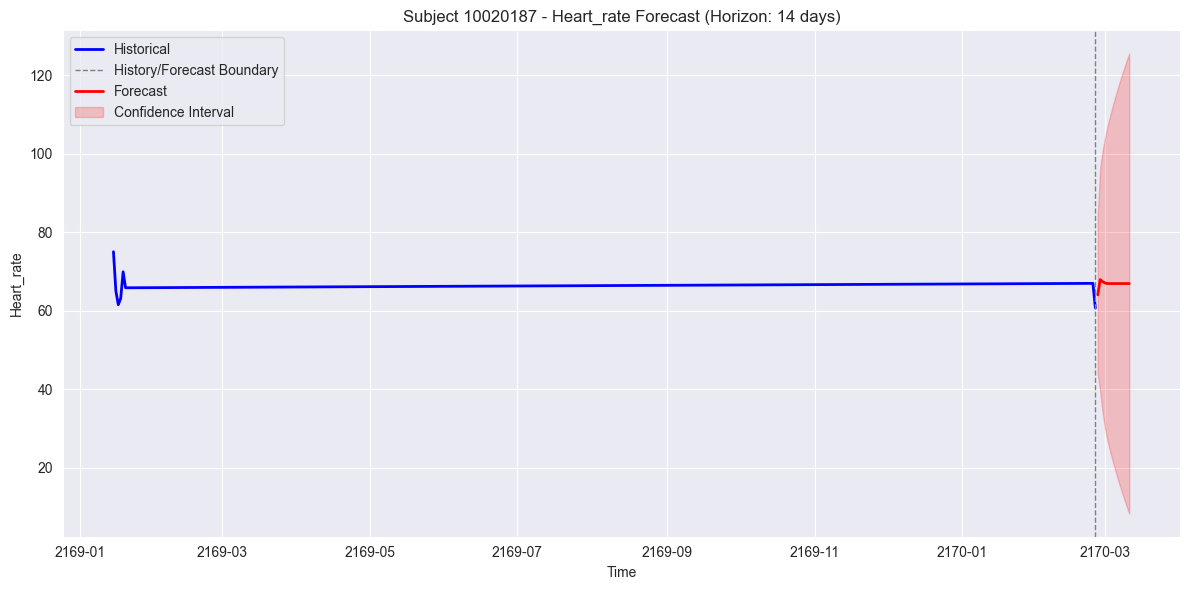

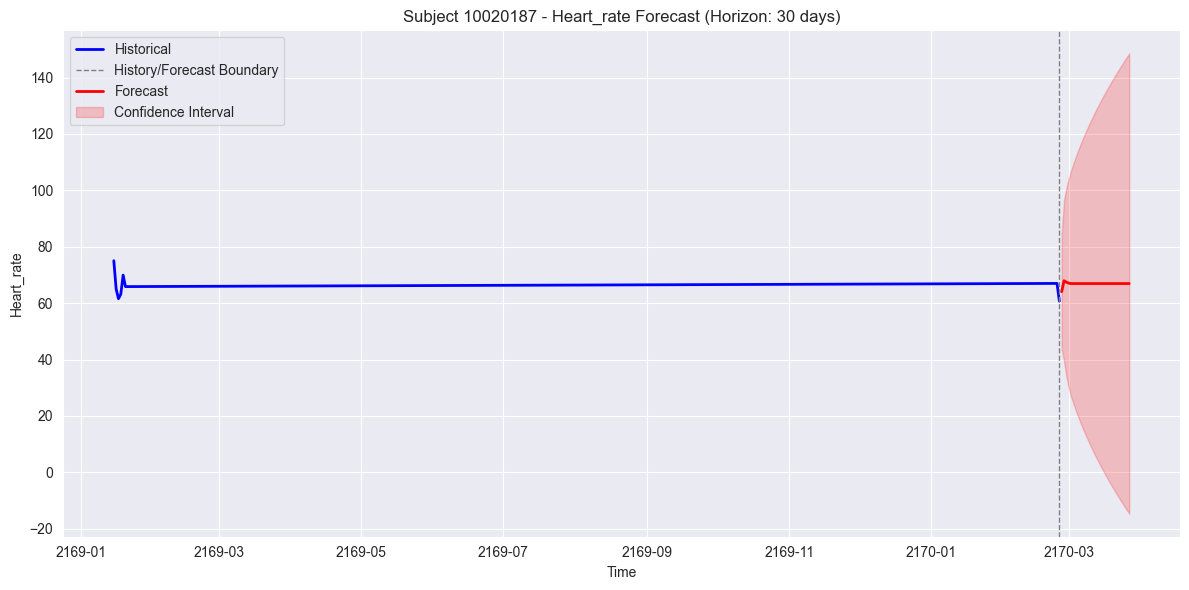

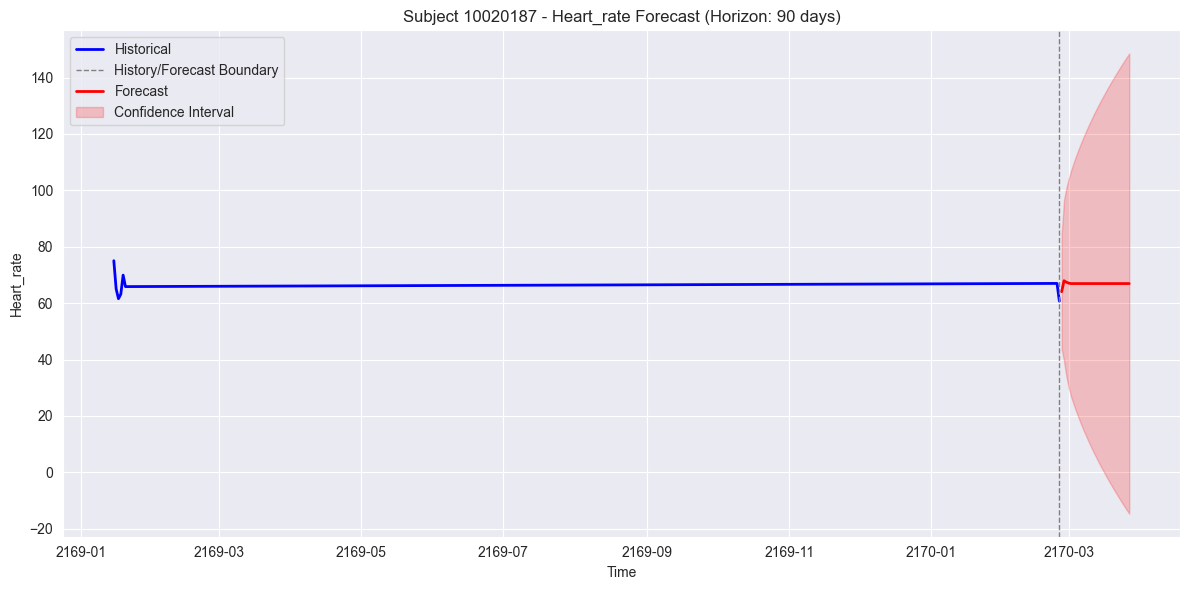

In [67]:
plot_forecast(final_results, 10020187, 'heart_rate', forecast_horizon=14)
plot_forecast(final_results, 10020187, 'heart_rate', forecast_horizon=30)
plot_forecast(final_results, 10020187, 'heart_rate', forecast_horizon=90)


In [35]:
final_results

,charttime,subject_id,heart_rate,forecast,forecast_lower,forecast_upper,metric,row_type
0,2169-01-15,10020187,75.050000,NaN,NaN,NaN,heart_rate,historical
1,2169-01-16,10020187,65.045455,NaN,NaN,NaN,heart_rate,historical
2,2169-01-17,10020187,61.571429,NaN,NaN,NaN,heart_rate,historical
3,2169-01-18,10020187,63.187500,NaN,NaN,NaN,heart_rate,historical
4,2169-01-19,10020187,69.947368,NaN,NaN,NaN,heart_rate,historical
...,...,...,...,...,...,...,...,...
368,2171-02-21,10020187,66.949343,66.949343,-203.619964,337.518649,heart_rate,forecast
369,2171-02-22,10020187,66.949343,66.949343,-203.991186,337.889871,heart_rate,forecast
370,2171-02-23,10020187,66.949343,66.949343,-204.361901,338.260586,heart_rate,forecast
371,2171-02-24,10020187,66.949343,66.949343,-204.732109,338.630794,heart_rate,forecast


In [37]:
# Review a specific subject, evaluate forcasting with source data
final_results[final_results['subject_id'] == 10020187]

,charttime,subject_id,heart_rate,forecast,forecast_lower,forecast_upper,metric,row_type
0,2169-01-15,10020187,75.050000,NaN,NaN,NaN,heart_rate,historical
1,2169-01-16,10020187,65.045455,NaN,NaN,NaN,heart_rate,historical
2,2169-01-17,10020187,61.571429,NaN,NaN,NaN,heart_rate,historical
3,2169-01-18,10020187,63.187500,NaN,NaN,NaN,heart_rate,historical
4,2169-01-19,10020187,69.947368,NaN,NaN,NaN,heart_rate,historical
...,...,...,...,...,...,...,...,...
368,2171-02-21,10020187,66.949343,66.949343,-203.619962,337.518647,heart_rate,forecast
369,2171-02-22,10020187,66.949343,66.949343,-203.991184,337.889870,heart_rate,forecast
370,2171-02-23,10020187,66.949343,66.949343,-204.361898,338.260584,heart_rate,forecast
371,2171-02-24,10020187,66.949343,66.949343,-204.732107,338.630792,heart_rate,forecast


In [38]:
vdf[vdf['subject_id'] == 10020187]

,subject_id,stay_id,charttime,heart_rate,sbp,dbp,mbp,sbp_ni,dbp_ni,mbp_ni,resp_rate,temperature,temperature_site,spo2,glucose
7035285,10020187,32554129,2170-02-24 18:24:00,78.0,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,None,100.0,NaN
7035286,10020187,32554129,2170-02-24 18:26:00,NaN,NaN,NaN,97.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
7035287,10020187,32554129,2170-02-24 18:27:00,NaN,140.0,69.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
7035288,10020187,32554129,2170-02-24 18:32:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.17,Oral,NaN,NaN
7035289,10020187,32554129,2170-02-24 19:00:00,62.0,133.0,64.0,88.0,NaN,NaN,NaN,16.0,36.89,Oral,95.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7035480,10020187,37509585,2169-01-20 12:01:00,56.0,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,Oral,98.0,NaN
7035481,10020187,37509585,2169-01-20 12:02:00,NaN,148.0,82.0,100.0,148.0,82.0,100.0,NaN,NaN,None,NaN,NaN
7035482,10020187,37509585,2169-01-20 13:51:00,73.0,NaN,NaN,NaN,NaN,NaN,NaN,22.0,NaN,None,96.0,NaN
7035483,10020187,37509585,2169-01-20 14:00:00,69.0,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN,None,97.0,NaN


## Prophet Model

In [64]:
# Set logging levels
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
logging.getLogger("prophet").setLevel(logging.WARNING)

# Assuming df is defined elsewhere
df_time = df.copy()
prophet_final_results = []
# Example parameters
metrics = ['heart_rate']
run_forecast_for_subjects = True  # Set to False if global only
selected_subjects = [10020187]  # Example subject_ids
max_forecast_days = 30  # Maximum forecast horizon

##################
# Data Validation
##################

# Check for invalid charttime rows and drop them
invalid_rows = df_time[df_time['charttime'].isna()]
if not invalid_rows.empty:
    print("Invalid charttime values found and will be dropped:")
    print(invalid_rows)
    df_time = df_time.dropna(subset=['charttime'])

# Ensure data is sorted by subject and charttime
df_time['charttime'] = pd.to_datetime(df_time['charttime'], errors='coerce')
df_time = df_time.dropna(subset=['charttime'])
df_time = df_time.sort_values(by=['subject_id', 'charttime'])
final = []
##################
# Helper Functions
##################

def clean_and_validate(df, column_name):
    """Validate and clean data, removing invalid, NaN or extreme values."""
    if column_name not in df.columns:
        raise ValueError(f"Column {column_name} not found in DataFrame.")
    df = df.dropna(subset=[column_name])
    df[column_name] = np.clip(df[column_name], -1e6, 1e6)
    finite_mask = np.isfinite(df[column_name])
    if not finite_mask.all():
        df = df[finite_mask]
    return df

def prepare_global_trend(df_time, metric):
    """
    Prepare the global trend (mean metric by charttime across all subjects).
    """
    global_trend = df_time.groupby('charttime')[metric].mean().dropna()
    global_trend.index = pd.to_datetime(global_trend.index, errors='coerce')
    global_trend = global_trend.sort_index().dropna()
    return global_trend

def forecast_with_global_trend_prophet(patient_df, metric, global_trend, global_model, full_global_forecast, max_forecast_days):
    # Extract subject_id
    if 'subject_id' not in patient_df.columns:
        raise ValueError("`patient_df` must have a 'subject_id' column.")
    subject_id = patient_df['subject_id'].iloc[0]

    # Check data sufficiency
    if patient_df[metric].dropna().empty:
        return pd.DataFrame()

    # Resample patient data daily
    patient_df = patient_df.set_index('charttime')
    patient_daily = patient_df.resample('D').ffill().reset_index()
    patient_daily.rename(columns={'charttime': 'ds', metric: 'y'}, inplace=True)
    patient_daily = clean_and_validate(patient_daily, 'y')
    if patient_daily.empty:
        return pd.DataFrame()

    start_date, end_date = patient_daily['ds'].min(), patient_daily['ds'].max()

    # Restrict global trend
    relevant_global = global_trend.loc[(global_trend.index >= start_date) &
                                       (global_trend.index <= end_date + pd.Timedelta(days=max_forecast_days))]
    if relevant_global.empty:
        return pd.DataFrame()

    global_trend_df = relevant_global.reset_index().rename(columns={'charttime': 'ds', metric: 'y'})
    global_trend_df = clean_and_validate(global_trend_df, 'y')
    if global_trend_df.empty:
        return pd.DataFrame()

    # Use global model and full_global_forecast
    future_global = full_global_forecast[full_global_forecast['ds'] > end_date]
    global_forecast = future_global.copy()

    # Compute residuals
    hist_global_forecast = global_model.predict(patient_daily[['ds']])
    aligned_global_forecast = hist_global_forecast.set_index('ds').reindex(patient_daily['ds'], method='nearest')['yhat']
    residuals = patient_daily['y'] - aligned_global_forecast.values

    # Fit residual model if enough data
    if residuals.dropna().shape[0] > 1:
        residuals_df = pd.DataFrame({'ds': patient_daily['ds'], 'y': residuals}).dropna()
        residuals_df = clean_and_validate(residuals_df, 'y')
        if not residuals_df.empty:
            residual_model = Prophet()
            try:
                residual_model.fit(residuals_df)
                residual_forecast = residual_model.predict(global_forecast[['ds']])
            except RuntimeError:
                logging.warning(f"Residual model failed for subject_id={subject_id}, metric={metric}. Using zero residuals.")
                residual_forecast = pd.DataFrame({'ds': global_forecast['ds'], 'yhat': 0, 'yhat_lower': 0, 'yhat_upper': 0})
        else:
            residual_forecast = pd.DataFrame({'ds': global_forecast['ds'], 'yhat': 0, 'yhat_lower': 0, 'yhat_upper': 0})
    else:
        residual_forecast = pd.DataFrame({'ds': global_forecast['ds'], 'yhat': 0, 'yhat_lower': 0, 'yhat_upper': 0})

    # Combine forecasts
    combined_forecast = global_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
    combined_forecast['yhat'] += residual_forecast['yhat'].values
    combined_forecast['yhat_lower'] += residual_forecast.get('yhat_lower', 0)
    combined_forecast['yhat_upper'] += residual_forecast.get('yhat_upper', 0)

    # Historical data
    historical_data = patient_daily.copy()
    historical_data['forecast'] = np.nan
    historical_data['forecast_lower'] = np.nan
    historical_data['forecast_upper'] = np.nan

    forecast_data = combined_forecast.copy()
    forecast_data.rename(columns={'yhat': 'forecast', 'yhat_lower': 'forecast_lower', 'yhat_upper': 'forecast_upper'}, inplace=True)

    full_data = pd.concat([historical_data, forecast_data], ignore_index=True)
    full_data.rename(columns={'ds': 'charttime', 'y': metric}, inplace=True)
    full_data['subject_id'] = subject_id

    # Keep needed columns from patient_df
    needed_cols = ['subject_id', 'charttime']  # If more columns are needed, add them here.
    patient_df = patient_df.reset_index()[needed_cols].drop_duplicates()

    # Merge
    full_merged = pd.merge(
        full_data,
        patient_df,
        on=['subject_id', 'charttime'],
        how='left'
    )

    # Ensure final columns
    cols_to_use = ['charttime', 'subject_id', metric, 'forecast', 'forecast_lower', 'forecast_upper']
    for col in cols_to_use:
        if col not in full_merged.columns:
            full_merged[col] = np.nan

    full_merged = full_merged[cols_to_use]

    return full_merged

def parallel_forecast(args):
    return forecast_with_global_trend_prophet(*args)

if __name__ == '__main__':
    results = []

    for metric in metrics:
        # Prepare global trend
        global_trend = prepare_global_trend(df_time, metric)
        if global_trend.empty:
            continue

        global_trend_df = global_trend.reset_index().rename(columns={'charttime': 'ds', metric: 'y'})
        global_trend_df = clean_and_validate(global_trend_df, 'y')
        if global_trend_df.empty:
            continue

        global_model = Prophet()
        global_model.fit(global_trend_df)

        future_global = global_model.make_future_dataframe(periods=max_forecast_days)
        full_global_forecast = global_model.predict(future_global)

        if run_forecast_for_subjects:
            if not selected_subjects:
                selected_subjects = df_time['subject_id'].unique()

            args_list = []
            for subject_id, group in df_time.groupby('subject_id'):
                if subject_id in selected_subjects:
                    if metric not in group.columns:
                        continue
                    args_list.append((group, metric, global_trend, global_model, full_global_forecast, max_forecast_days))

            if len(args_list) == 1:
                # Single subject
                res = forecast_with_global_trend_prophet(*args_list[0])
                if not res.empty:
                    res['metric'] = metric
                    results.append(res)
            else:
                # Multiple subjects in parallel
                with Pool(processes=cpu_count()) as p:
                    parallel_results = p.map(parallel_forecast, args_list)
                parallel_results = [r for r in parallel_results if not r.empty]
                for r in parallel_results:
                    r['metric'] = metric
                    results.append(r)
        else:
            # Global-only computations if needed
            pass

    if results:
        prophet_final_results = pd.concat(results, ignore_index=True)
        # Create row_type column
        prophet_final_results['row_type'] = np.where(prophet_final_results['forecast'].notna(), 'forecast', 'historical')

        # Overwrite metric values with forecast where available
        metric = metrics[0]
        prophet_final_results[metric] = np.where(prophet_final_results['forecast'].notna(), prophet_final_results['forecast'], prophet_final_results[metric])

        final.append(prophet_final_results)
        # Just print the first 10 rows for inspection
        print(prophet_final_results.head(10))
    else:
        print("No forecasts were generated.")
    plr()

   charttime  subject_id  heart_rate  forecast  forecast_lower  \
0 2169-01-15    10020187   75.050000       NaN             NaN   
1 2169-01-16    10020187   65.045455       NaN             NaN   
2 2169-01-17    10020187   61.571429       NaN             NaN   
3 2169-01-18    10020187   63.187500       NaN             NaN   
4 2169-01-19    10020187   69.947368       NaN             NaN   
5 2169-01-20    10020187   65.875000       NaN             NaN   
6 2169-01-21    10020187   65.875000       NaN             NaN   
7 2169-01-22    10020187   65.875000       NaN             NaN   
8 2169-01-23    10020187   65.875000       NaN             NaN   
9 2169-01-24    10020187   65.875000       NaN             NaN   

   forecast_upper      metric    row_type  
0             NaN  heart_rate  historical  
1             NaN  heart_rate  historical  
2             NaN  heart_rate  historical  
3             NaN  heart_rate  historical  
4             NaN  heart_rate  historical  
5        

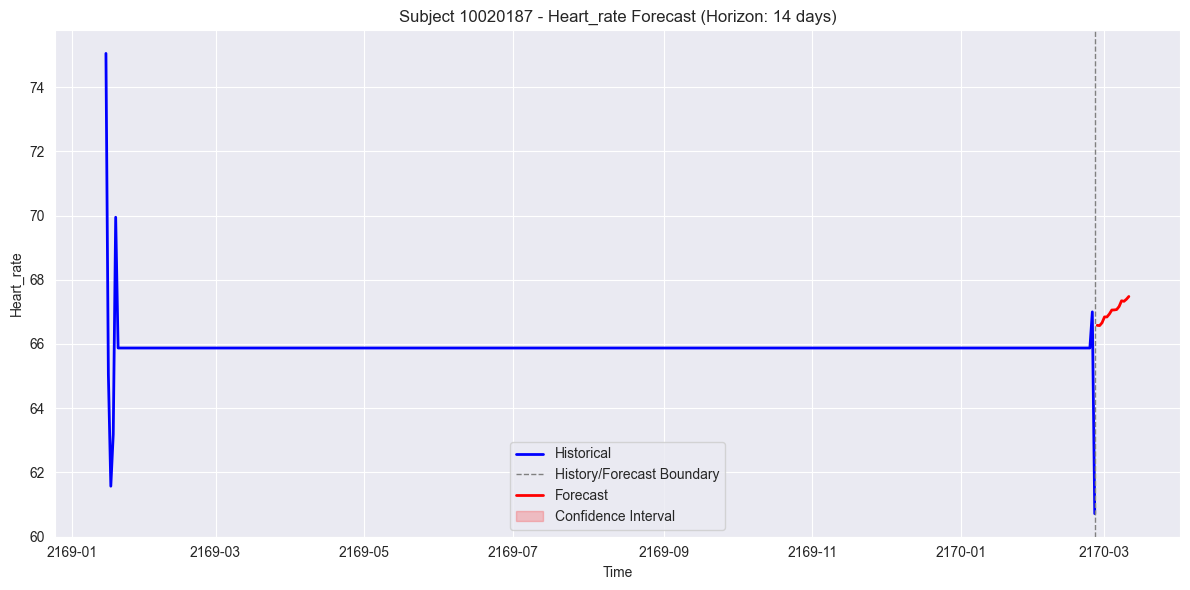

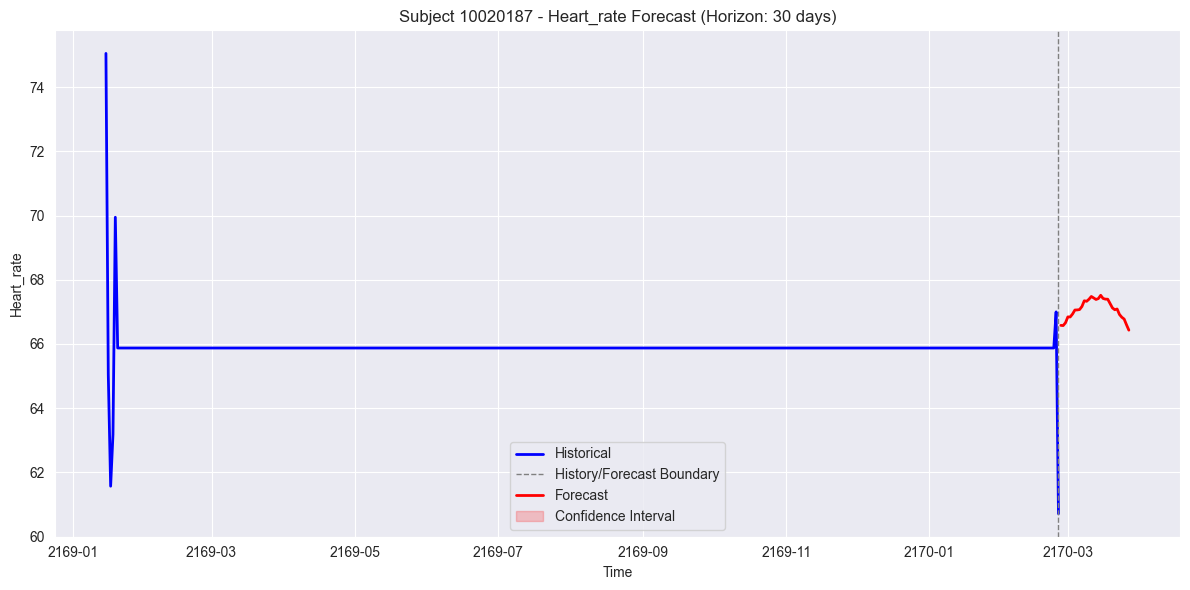

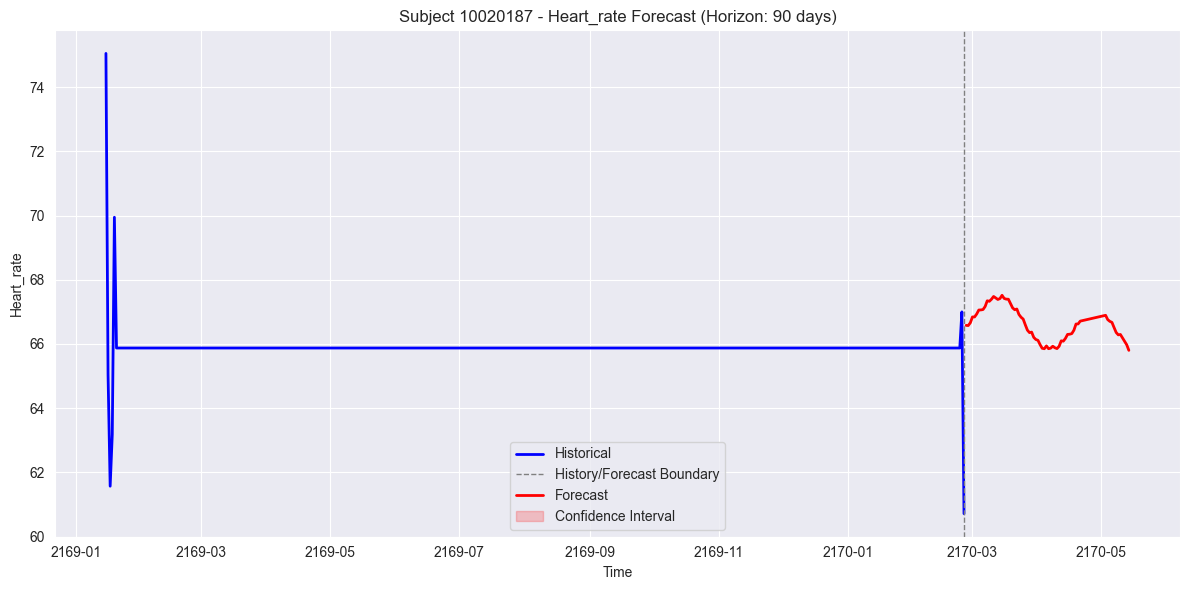

In [69]:
plot_forecast(prophet_final_results, 10020187, 'heart_rate', forecast_horizon=14)
plot_forecast(prophet_final_results, 10020187, 'heart_rate', forecast_horizon=30)
plot_forecast(prophet_final_results, 10020187, 'heart_rate', forecast_horizon=90)


In [70]:
df_check = prophet_final_results[(prophet_final_results['subject_id'] == 10020187) & (prophet_final_results['metric'] == 'heart_rate')]
print(df_check.head())
print(df_check.shape)


   charttime  subject_id  heart_rate  forecast  forecast_lower  \
0 2169-01-15    10020187   75.050000       NaN             NaN   
1 2169-01-16    10020187   65.045455       NaN             NaN   
2 2169-01-17    10020187   61.571429       NaN             NaN   
3 2169-01-18    10020187   63.187500       NaN             NaN   
4 2169-01-19    10020187   69.947368       NaN             NaN   

   forecast_upper      metric    row_type  
0             NaN  heart_rate  historical  
1             NaN  heart_rate  historical  
2             NaN  heart_rate  historical  
3             NaN  heart_rate  historical  
4             NaN  heart_rate  historical  
(4740, 8)


In [71]:
prophet_final_results[prophet_final_results['subject_id'] == 10020187]


,charttime,subject_id,heart_rate,forecast,forecast_lower,forecast_upper,metric,row_type
0,2169-01-15,10020187,75.050000,NaN,NaN,NaN,heart_rate,historical
1,2169-01-16,10020187,65.045455,NaN,NaN,NaN,heart_rate,historical
2,2169-01-17,10020187,61.571429,NaN,NaN,NaN,heart_rate,historical
3,2169-01-18,10020187,63.187500,NaN,NaN,NaN,heart_rate,historical
4,2169-01-19,10020187,69.947368,NaN,NaN,NaN,heart_rate,historical
...,...,...,...,...,...,...,...,...
4735,2211-12-23,10020187,190.038658,190.038658,NaN,NaN,heart_rate,forecast
4736,2211-12-24,10020187,190.075604,190.075604,NaN,NaN,heart_rate,forecast
4737,2211-12-25,10020187,190.202981,190.202981,NaN,NaN,heart_rate,forecast
4738,2211-12-26,10020187,190.418461,190.418461,NaN,NaN,heart_rate,forecast


In [72]:
vdf[vdf['subject_id'] == 10020187]

,subject_id,stay_id,charttime,heart_rate,sbp,dbp,mbp,sbp_ni,dbp_ni,mbp_ni,resp_rate,temperature,temperature_site,spo2,glucose
7035285,10020187,32554129,2170-02-24 18:24:00,78.0,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,None,100.0,NaN
7035286,10020187,32554129,2170-02-24 18:26:00,NaN,NaN,NaN,97.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
7035287,10020187,32554129,2170-02-24 18:27:00,NaN,140.0,69.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
7035288,10020187,32554129,2170-02-24 18:32:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.17,Oral,NaN,NaN
7035289,10020187,32554129,2170-02-24 19:00:00,62.0,133.0,64.0,88.0,NaN,NaN,NaN,16.0,36.89,Oral,95.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7035480,10020187,37509585,2169-01-20 12:01:00,56.0,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,Oral,98.0,NaN
7035481,10020187,37509585,2169-01-20 12:02:00,NaN,148.0,82.0,100.0,148.0,82.0,100.0,NaN,NaN,None,NaN,NaN
7035482,10020187,37509585,2169-01-20 13:51:00,73.0,NaN,NaN,NaN,NaN,NaN,NaN,22.0,NaN,None,96.0,NaN
7035483,10020187,37509585,2169-01-20 14:00:00,69.0,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN,None,97.0,NaN


# Supervised Models: `Random Forest`
Predicting subject diagnosis, from unsupervised model outputs

In [73]:
df.head()

,subject_id,charttime,heart_rate,resp_rate,mbp,temperature,spo2,umap_x,umap_y,kmeans_cluster,distance_to_center,kmeans_outlier,dbscan_label,dbscan_outlier,umap_dbscan_label,umap_dbscan_outlier,outlier_combination
303,10006053,2111-11-14,104.074074,24.517241,73.820000,36.080000,97.814815,4.222461,10.868479,2,2.903607,True,-1,True,0,False,KMeans & DBSCAN
304,10006053,2111-11-15,95.736842,21.388889,60.294118,37.211667,93.125000,3.489141,7.247446,2,2.254773,False,-1,True,0,False,DBSCAN
354,10008100,2181-12-10,86.250000,18.000000,98.000000,35.890000,99.000000,8.803664,3.181862,0,2.796236,False,-1,True,0,False,DBSCAN
355,10008100,2181-12-11,74.928571,17.692308,83.000000,36.430000,97.923077,9.348326,7.565651,0,0.799730,False,0,False,0,False,No Outlier
564,10012476,2163-01-10,56.480000,15.120000,65.200000,36.731667,98.458333,10.061695,7.017820,0,1.848693,False,-1,True,0,False,DBSCAN


In [105]:
sdf = df.copy()

# Convert boolean outlier columns to integers
sdf['kmeans_outlier'] = sdf['kmeans_outlier'].astype(int)
sdf['dbscan_outlier'] = sdf['dbscan_outlier'].astype(int)
sdf['umap_dbscan_outlier'] = sdf['umap_dbscan_outlier'].astype(int)


# Aggregate outlier columns into a single score
sdf['outlier_score'] = (
        sdf['kmeans_outlier'] +
        sdf['dbscan_outlier'] +
        sdf['umap_dbscan_outlier']
)

# One-hot encode the 'outlier_combination' column
sdf = pd.get_dummies(sdf, columns=['outlier_combination'], prefix='outlier_comb')

# Drop unnecessary columns
sdf = sdf.drop(columns=['charttime'])


# Check data types
print(sdf.dtypes)



subject_id                        int64
heart_rate                      float64
resp_rate                       float64
mbp                             float64
temperature                     float64
spo2                            float64
umap_x                          float32
umap_y                          float32
kmeans_cluster                    int32
distance_to_center              float64
kmeans_outlier                    int32
dbscan_label                      int64
dbscan_outlier                    int32
umap_dbscan_label                 int64
umap_dbscan_outlier               int32
outlier_score                     int32
outlier_comb_DBSCAN                bool
outlier_comb_KMeans & DBSCAN       bool
outlier_comb_No Outlier            bool
dtype: object


In [108]:
# Define features and target
# X = sdf.drop(columns=['heart_rate'])  # Use all columns except 'heart_rate' as features

non_hr_vitals = [col for col in cols_vitals if col != 'heart_rate']  # Remove 'heart_rate'


X = sdf[non_hr_vitals]  # Use all columns except 'heart_rate' as features
y = sdf['heart_rate']                 # Target variable: 'heart_rate'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Regressor
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
# Baseline MSE: Predicting the mean of the training target
baseline_pred = [y_train.mean()] * len(y_test)
baseline_mse = mean_squared_error(y_test, baseline_pred)

# Model MSE
model_mse = mean_squared_error(y_test, y_pred)

# RMSE
model_rmse = model_mse ** 0.5

# R² Score
model_r2 = r2_score(y_test, y_pred)

# Display summary of results
print("Random Forest Results:")
print(f"Baseline MSE: {baseline_mse:.2f}")
print(f"Model MSE: {model_mse:.2f}")
print(f"Model RMSE: {model_rmse:.2f}")
print(f"R-squared (R²): {model_r2:.2f}")

Random Forest Results:
Baseline MSE: 237.34
Model MSE: 227.81
Model RMSE: 15.09
R-squared (R²): 0.04


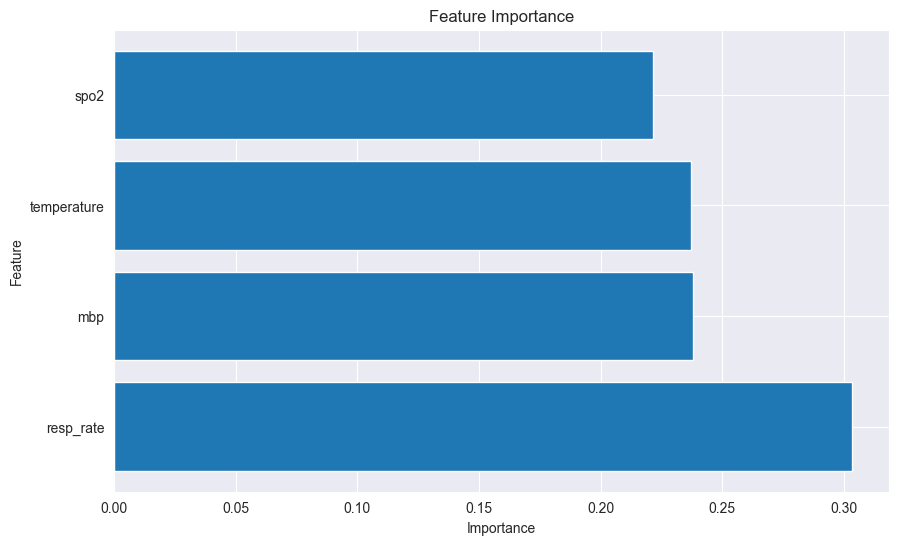

In [109]:
feature_importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importances)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()